<a href="https://colab.research.google.com/github/omar-omar-om/gradProject-notebooks/blob/main/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [ ]:
!pip install category-encoders
!pip install xlsxwriter


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import gc
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from category_encoders import TargetEncoder, OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
import xlsxwriter
import pickle
import json





# Reading from google drive

In [ ]:

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset path
dataset_path = '/content/drive/My Drive/microsoft-malware-prediction/train.csv'
nrows_to_load = 3000000  # Load only the first 3 million rows

# Load the first 3 million rows
data = pd.read_csv(dataset_path, nrows=nrows_to_load)

# Preview the dataset
print(data.head())

print("First 3 million rows loaded and ready for processing.")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-36-6203cbf7fa70>:9: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_path, nrows=nrows_to_load)


                  MachineIdentifier   ProductName EngineVersion  \
0  0000028988387b115f69f31a3bf04f09  win8defender   1.1.15100.1   
1  000007535c3f730efa9ea0b7ef1bd645  win8defender   1.1.14600.4   
2  000007905a28d863f6d0d597892cd692  win8defender   1.1.15100.1   
3  00000b11598a75ea8ba1beea8459149f  win8defender   1.1.15100.1   
4  000014a5f00daa18e76b81417eeb99fc  win8defender   1.1.15100.1   

        AppVersion  AvSigVersion  IsBeta  RtpStateBitfield  IsSxsPassiveMode  \
0  4.18.1807.18075  1.273.1735.0       0            7.0000                 0   
1     4.13.17134.1    1.263.48.0       0            7.0000                 0   
2  4.18.1807.18075  1.273.1341.0       0            7.0000                 0   
3  4.18.1807.18075  1.273.1527.0       0            7.0000                 0   
4  4.18.1807.18075  1.273.1379.0       0            7.0000                 0   

   DefaultBrowsersIdentifier  AVProductStatesIdentifier  ...  \
0                        NaN                53,447.0

# Pre-processing

Before doing anything, it is important to drop unnecessary columns to save memory. Columns with many missing values and extremely skewed values will be dropped.

In [ ]:
# Get the total number of rows
total_rows = len(data)

# Initialize an empty list to store column names and missing percentages
missing_data = []

# Loop through each column and calculate the missing value percentage
for column in data.columns:
    missing_count = data[column].isnull().sum()  # Count missing values for each column
    missing_percentage = (missing_count / total_rows) * 100  # Calculate the percentage
    missing_data.append([column, missing_percentage])  # Store column name and percentage

# Create a DataFrame from the list
missing_df = pd.DataFrame(missing_data, columns=['Column Name', 'Missing Value Percentage'])

# Sort the DataFrame by missing percentage
missing_df = missing_df.sort_values(by='Missing Value Percentage', ascending=False)

# Display the result
missing_df


,Column Name,Missing Value Percentage
28,PuaMode,99.9735
41,Census_ProcessorClass,99.5881
8,DefaultBrowsersIdentifier,95.1365
68,Census_IsFlightingInternal,83.0300
52,Census_InternalBatteryType,71.0150
...,...,...
1,ProductName,0.0000
45,Census_HasOpticalDiskDrive,0.0000
54,Census_OSVersion,0.0000
55,Census_OSArchitecture,0.0000


In [ ]:
# Set display format for float values
pd.options.display.float_format = '{:,.4f}'.format

# Create a DataFrame with column names, unique value counts, and skewness (most frequent value percentage)
sk_df = pd.DataFrame([
    {'column': c,
     'uniq': data[c].nunique(),
     'skewness': data[c].value_counts(normalize=True).values[0] * 100}
    for c in data.columns
])

# Sort the DataFrame by skewness in descending order
sk_df = sk_df.sort_values('skewness', ascending=False)

# Display the result
sk_df


,column,uniq,skewness
28,PuaMode,1,100.0000
75,Census_IsWIMBootEnabled,1,100.0000
5,IsBeta,2,99.9992
69,Census_IsFlightsDisabled,2,99.9991
68,Census_IsFlightingInternal,2,99.9980
...,...,...,...
4,AvSigVersion,8180,1.1522
14,CityIdentifier,77241,1.1111
73,Census_FirmwareVersionIdentifier,39141,1.0299
44,Census_SystemVolumeTotalCapacity,362357,0.5881


<p>These 2 codes showed that 16 columns need to be removed because they have missing values of more than 99% and are fully skewed, which doesn't make them useful for our model and analysis.</p>
<p>Columns that are 100% useless:</p>
<ul>
  <li>PuaMode</li>
  <li>Census_ProcessorClass</li>
  <li>Census_IsWIMBootEnabled</li>
  <li>IsBeta</li>
  <li>Census_IsFlightsDisabled</li>
  <li>Census_IsFlightingInternal</li>
  <li>AutoSampleOptIn</li>
  <li>Census_ThresholdOptIn</li>
  <li>SMode</li>
  <li>Census_IsPortableOperatingSystem</li>
  <li>Census_DeviceFamily</li>
  <li>UacLuaenable</li>
  <li>Census_IsVirtualDevice</li>
  <li>Platform</li>
  <li>ProductName</li>
  <li>HasTpm</li>



</ul>


In [ ]:
# List of columns to drop
columns_to_drop = [
    "PuaMode",
    "Census_ProcessorClass",
    "Census_IsWIMBootEnabled",
    "IsBeta",
    "Census_IsFlightsDisabled",
    "Census_IsFlightingInternal",
    "AutoSampleOptIn",
    "Census_ThresholdOptIn",
    "SMode",
    "Census_IsPortableOperatingSystem",
    "Census_DeviceFamily",
    "UacLuaenable",
    "Census_IsVirtualDevice",
    "Platform",
    "ProductName",
    "HasTpm"
]

df = data.drop(columns=columns_to_drop)
df.shape


(3000000, 67)

The up analysis was important to compare with work that used the whole dataset. For example, this one---> https://www.kaggle.com/code/jiegeng94/everyone-do-this-at-the-beginning    -- has used the whole dataset, so I compared my missing value and skewness with his to make sure random sampling was representative.

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 67 columns):
 #   Column                                             Dtype  
---  ------                                             -----  
 0   MachineIdentifier                                  object 
 1   EngineVersion                                      object 
 2   AppVersion                                         object 
 3   AvSigVersion                                       object 
 4   RtpStateBitfield                                   float64
 5   IsSxsPassiveMode                                   int64  
 6   DefaultBrowsersIdentifier                          float64
 7   AVProductStatesIdentifier                          float64
 8   AVProductsInstalled                                float64
 9   AVProductsEnabled                                  float64
 10  CountryIdentifier                                  int64  
 11  CityIdentifier                                    

There are quite a few columns that have nan values, but i can just remove the rows because they are less than 10% of nan values, and since I already have 3 million columns it is fine. The only issue is columns that have more than 10% of nan values.
these columns are:
- DefaultBrowserIdentifier
- OrganizationIdentifier
- SmartScreen
- Census_InternalBatteryType

Lets inspect these columns more in depth

In [ ]:
df[['DefaultBrowsersIdentifier', 'SmartScreen', 'Census_InternalBatteryType', 'OrganizationIdentifier']].head(100)

,DefaultBrowsersIdentifier,SmartScreen,Census_InternalBatteryType,OrganizationIdentifier
0,NaN,NaN,NaN,18.0000
1,NaN,NaN,NaN,18.0000
2,NaN,RequireAdmin,NaN,18.0000
3,NaN,ExistsNotSet,NaN,NaN
4,NaN,RequireAdmin,lion,NaN
...,...,...,...,...
95,NaN,NaN,NaN,18.0000
96,NaN,RequireAdmin,NaN,NaN
97,NaN,RequireAdmin,lion,27.0000
98,NaN,RequireAdmin,NaN,NaN


lets inspect unique values of each column

In [ ]:
default =df['SmartScreen'].value_counts()
default

,count
SmartScreen,
RequireAdmin,1450981
ExistsNotSet,351340
Off,63073
Warn,45443
Prompt,11623
Block,7561
off,455
On,245
&#x02;,136


In [ ]:
smartScreen_dict = {
    'off': 'Off',
    'on': 'On',
    '&#x02': '2',
    'Promt': 'Prompt',
    'OFF': 'Off',
    '&#x01': '1',
    'requireadmin': 'RequireAdmin',
    np.nan: 'Unknown'  # Handling NaN values
}

df['SmartScreen'] = df['SmartScreen'].replace(smartScreen_dict)
df['SmartScreen'].fillna('Unknown', inplace=True)  # Ensures any remaining NaNs are replaced


<ipython-input-44-d708ac7aa883>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['SmartScreen'].fillna('Unknown', inplace=True)  # Ensures any remaining NaNs are replaced


In [ ]:
battery =df['Census_InternalBatteryType'].value_counts()
battery

,count
Census_InternalBatteryType,
lion,682239
li-i,82883
#,62252
lip,21020
liio,10830
li p,2840
li,2270
nimh,1620
real,912


In [ ]:

battery_replace_dict = {
    # Standardizing common battery types
    'lion': 'Li-Ion',
    'li-i': 'Li-Ion',
    'lip': 'Li-Polymer',
    'liio': 'Li-Ion',
    'li p': 'Li-Polymer',
    'li': 'Lithium-based',
    'nimh': 'NiMH',
    'lipo': 'Li-Polymer',
    'pbac': 'Lead-Acid',
    '4cel': '4-cell',
    '4ion': 'Li-Ion',
    '3ion': 'Li-Ion',

    # Handling virtual machines or no battery cases
    'vbox': 'VirtualMachine',
    'virt': 'VirtualMachine',

    # Replacing all bad, unknown, and corrupted values with "Unknown"
    '#': 'Unknown',
    'real': 'Unknown',
    'unkn': 'Unknown',
    'bq20': 'Unknown',
    'lgi0': 'Unknown',
    'lhp0': 'Unknown',
    'ithi': 'Unknown',
    'lipp': 'Unknown',
    'bad': 'Unknown',
    'ram': 'Unknown',
    'ÿÿÿÿ': 'Unknown',
    'lio': 'Unknown',
    '0x0b': 'Unknown',
    'h4°s': 'Unknown',
    '÷ÿóö': 'Unknown',
    'í-i': 'Unknown',
    'icp3': 'Unknown',
    'ca48': 'Unknown',
    'pad0': 'Unknown',
    'p-sn': 'Unknown',
    '5nm1': 'Unknown',
    'pa50': 'Unknown',
    'a132': 'Unknown',
    'a140': 'Unknown',
    'asmb': 'Unknown',
    'cl53': 'Unknown',
    'ots0': 'Unknown',
    'lai0': 'Unknown',
    'sail': 'Unknown',
    '0ts0': 'Unknown',
    'd': 'Unknown',
    'lilo': 'Unknown',
    'li-l': 'Unknown',
    'lhpo': 'Unknown',
}

# Apply replacement and fill NaN values with "Unknown"
df['Census_InternalBatteryType'] = df['Census_InternalBatteryType'].replace(battery_replace_dict)
df['Census_InternalBatteryType'].fillna('Unknown', inplace=True)



<ipython-input-46-e4f0ecd1bc19>:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Census_InternalBatteryType'].fillna('Unknown', inplace=True)


This part is important to check , if we have 0 then nan will be replaced with -1 if not then will be replaced normally with a 0.

In [ ]:
# Check if 0 is already present in the identifier columns
print("Count of 0 in OrganizationIdentifier:", (df["OrganizationIdentifier"] == 0).sum())
print("Count of 0 in DefaultBrowsersIdentifier:", (df["DefaultBrowsersIdentifier"] == 0).sum())


Count of 0 in OrganizationIdentifier: 0
Count of 0 in DefaultBrowsersIdentifier: 0


For numerical columns replace nan with 0, because these are identifiers, so taking average or median does not make sense. Also taking mode could introduce more bias to the larger category.

In [ ]:
df[['OrganizationIdentifier', 'DefaultBrowsersIdentifier']] = df[['OrganizationIdentifier', 'DefaultBrowsersIdentifier']].fillna(0)


important step is also removing the machine identifier column as it has no effect for the model.

In [ ]:
df = df.drop(columns=['MachineIdentifier'])

In [ ]:
gc.collect()

0

In [ ]:
df.isna().sum()

,0
EngineVersion,0
AppVersion,0
AvSigVersion,0
RtpStateBitfield,10828
IsSxsPassiveMode,0
...,...
Census_IsPenCapable,0
Census_IsAlwaysOnAlwaysConnectedCapable,24032
Wdft_IsGamer,101912
Wdft_RegionIdentifier,101912


As mentioned earlier , column wioth less than 10% null values will just be removed as the dataset is already big enough.

In [ ]:
df = df.dropna(axis=0)

In [ ]:
df.shape

(2578105, 66)

this step is just to check what happened to skewness for ther columns that i deleted the nan rows , and as expected nothing much has happened.

In [ ]:
# Set display format for float values
pd.options.display.float_format = '{:,.4f}'.format

# Create a DataFrame with column names, unique value counts, and skewness (most frequent value percentage)
df_summary = pd.DataFrame([
    {'column': c,
     'uniq': df[c].nunique(),
     'skewness': df[c].value_counts(normalize=True).values[0] * 100}
    for c in df.columns
])

# Sort the DataFrame by skewness in descending order
df_summary = df_summary.sort_values('skewness', ascending=False)

df_summary


,column,uniq,skewness
15,OsVer,34,98.3633
4,IsSxsPassiveMode,2,98.1673
24,Firewall,2,97.9573
8,AVProductsEnabled,6,97.5575
3,RtpStateBitfield,7,97.2894
...,...,...,...
27,Census_OEMModelIdentifier,96224,3.3862
2,AvSigVersion,8050,1.1913
10,CityIdentifier,74029,1.1487
58,Census_FirmwareVersionIdentifier,36116,1.0756


In [ ]:
# Select only non-numeric columns from the DataFrame
non_numeric_cols = df.select_dtypes(exclude=['number'])

# Calculate the cardinality (number of unique values) for each non-numeric column
cardinality = non_numeric_cols.nunique()

#  display the results in a DataFrame format
cardinality_df = cardinality.reset_index()
cardinality_df.columns = ['Column', 'Cardinality']

print(cardinality_df)

                              Column  Cardinality
0                      EngineVersion           63
1                         AppVersion           98
2                       AvSigVersion         8050
3                          Processor            3
4                              OsVer           34
5               OsPlatformSubRelease            9
6                         OsBuildLab          468
7                         SkuEdition            7
8                        SmartScreen           10
9              Census_MDC2FormFactor           11
10        Census_PrimaryDiskTypeName            4
11            Census_ChassisTypeName           40
12      Census_PowerPlatformRoleName            9
13        Census_InternalBatteryType           13
14                  Census_OSVersion          343
15             Census_OSArchitecture            3
16                   Census_OSBranch           18
17                  Census_OSEdition           25
18                  Census_OSSkuName           20


Get the MI of each categorical feature towards the target feature

                             Feature  MI Score
8                        SmartScreen    0.0296
2                       AvSigVersion    0.0136
0                      EngineVersion    0.0089
1                         AppVersion    0.0068
6                         OsBuildLab    0.0049
14                  Census_OSVersion    0.0037
3                          Processor    0.0029
15             Census_OSArchitecture    0.0029
9              Census_MDC2FormFactor    0.0027
12      Census_PowerPlatformRoleName    0.0024
16                   Census_OSBranch    0.0020
11            Census_ChassisTypeName    0.0017
5               OsPlatformSubRelease    0.0013
19          Census_OSInstallTypeName    0.0013
17                  Census_OSEdition    0.0011
18                  Census_OSSkuName    0.0011
22          Census_ActivationChannel    0.0010
20  Census_OSWUAutoUpdateOptionsName    0.0007
10        Census_PrimaryDiskTypeName    0.0003
13        Census_InternalBatteryType    0.0002
7            

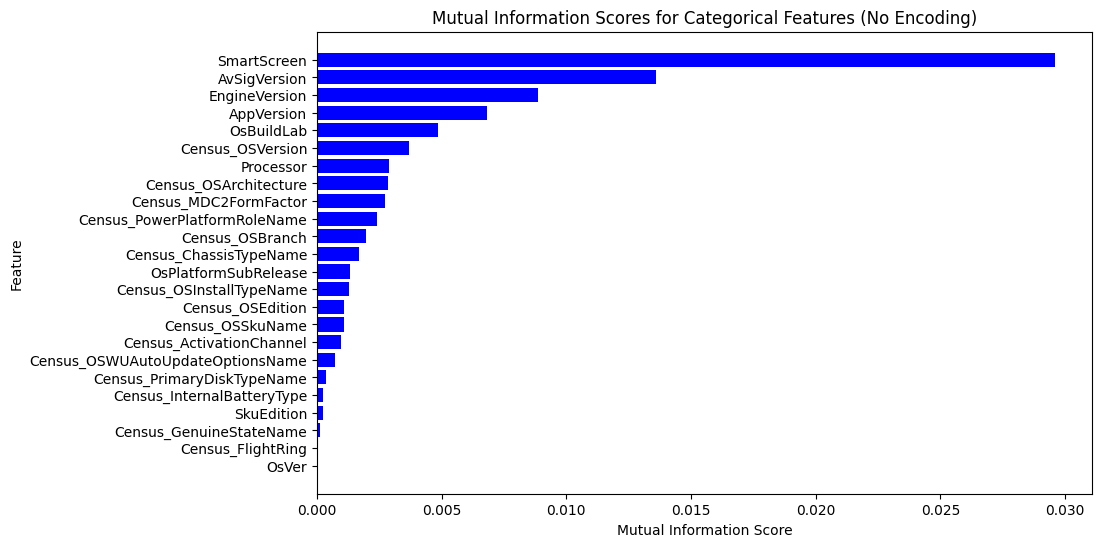

In [ ]:


# List of categorical columns
categorical_cols = [
    "EngineVersion", "AppVersion", "AvSigVersion", "Processor", "OsVer",
    "OsPlatformSubRelease", "OsBuildLab", "SkuEdition", "SmartScreen",
    "Census_MDC2FormFactor", "Census_PrimaryDiskTypeName", "Census_ChassisTypeName",
    "Census_PowerPlatformRoleName", "Census_InternalBatteryType", "Census_OSVersion",
    "Census_OSArchitecture", "Census_OSBranch", "Census_OSEdition", "Census_OSSkuName",
    "Census_OSInstallTypeName", "Census_OSWUAutoUpdateOptionsName", "Census_GenuineStateName",
    "Census_ActivationChannel", "Census_FlightRing"
]

# Ensure categorical variables are treated as categories
df[categorical_cols] = df[categorical_cols].astype('category')

# Compute Mutual Information Scores (without encoding)
mi_scores = mutual_info_classif(df[categorical_cols], df['HasDetections'], discrete_features=True)

# Store results in DataFrame
mi_results = pd.DataFrame({'Feature': categorical_cols, 'MI Score': mi_scores})
mi_results = mi_results.sort_values(by='MI Score', ascending=False)

# Display MI Scores
print(mi_results)

# Plot the Mutual Information Scores
plt.figure(figsize=(10, 6))
plt.barh(mi_results['Feature'], mi_results['MI Score'], color='blue')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.title('Mutual Information Scores for Categorical Features (No Encoding)')
plt.gca().invert_yaxis()  # Show highest scores on top
plt.show()


0 prdicitive power

                           OsVer    0.0000


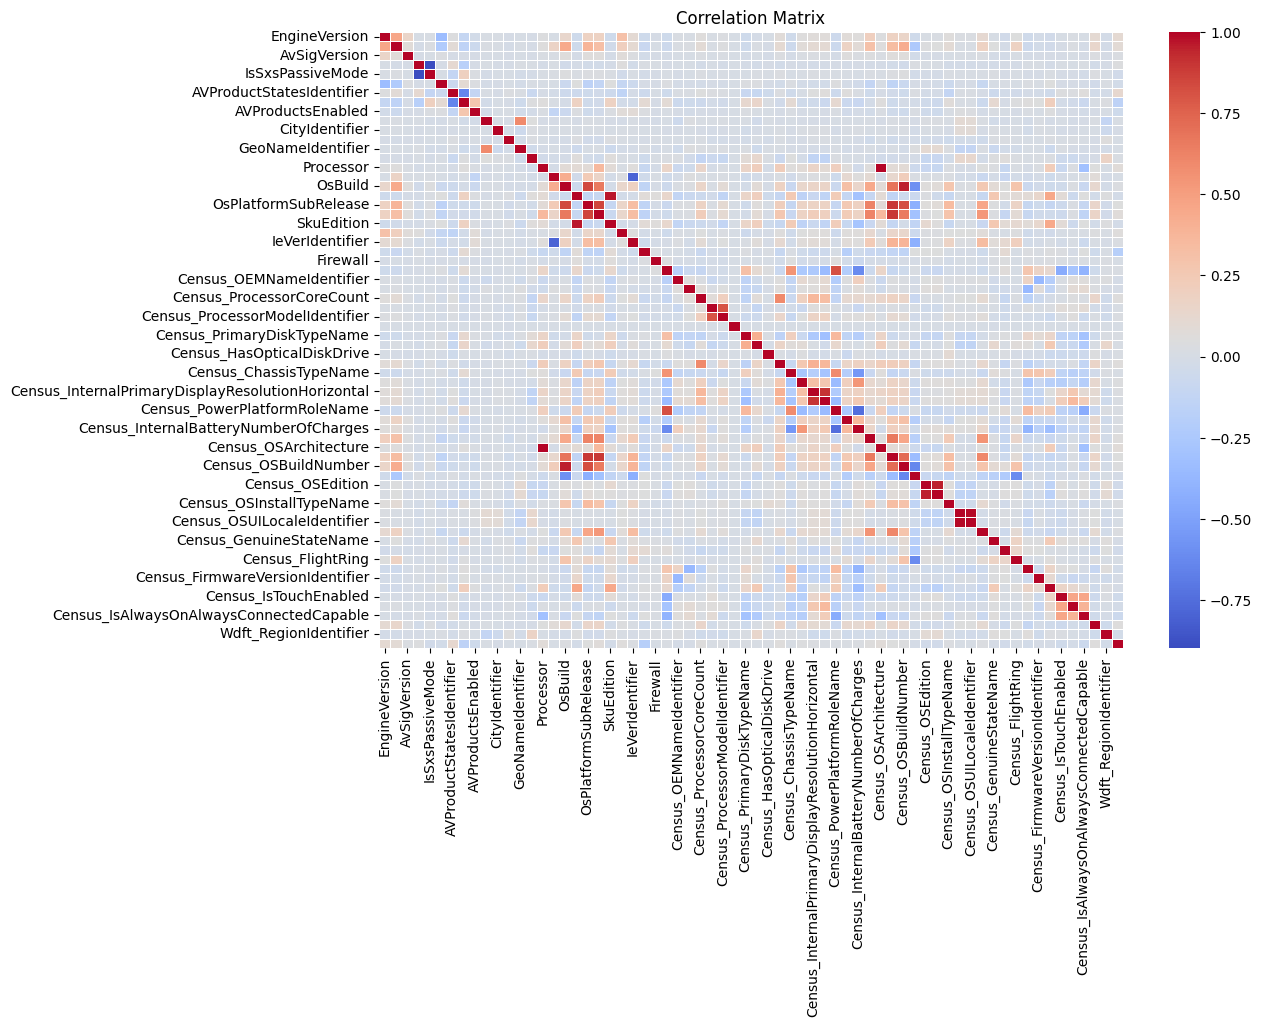

Highly Correlated Features (>|0.96|):
                             Feature 1                           Feature 2  \
15                           Processor               Census_OSArchitecture   
19                             OsSuite                          SkuEdition   
22                          SkuEdition                             OsSuite   
47               Census_OSArchitecture                           Processor   
56  Census_OSInstallLanguageIdentifier         Census_OSUILocaleIdentifier   
57         Census_OSUILocaleIdentifier  Census_OSInstallLanguageIdentifier   

    Correlation  
15       0.9957  
19       0.9655  
22       0.9655  
47       0.9957  
56       0.9881  
57       0.9881  


In [ ]:

# Step 1: Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
numerical_cols = df.select_dtypes(include=['number']).columns

# Step 2: Apply Frequency Encoding to categorical columns
freq_encoding = {}
for col in categorical_cols:
    freq_encoding[col] = df[col].value_counts().to_dict()
    df[col] = df[col].map(freq_encoding[col])

# Step 3: Compute the correlation matrix
corr_matrix = df.corr()

# Step 4: Convert categorical columns back to original values
for col in categorical_cols:
    df[col] = df[col].map({v: k for k, v in freq_encoding[col].items()})

# Step 5: Extract highly correlated features (above 96% or below -96%)
high_corr_pairs = corr_matrix[abs(corr_matrix) > 0.96].stack().reset_index()
high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_corr_pairs = high_corr_pairs[high_corr_pairs['Feature 1'] != high_corr_pairs['Feature 2']]  # Remove self-correlation

# Step 6: Plot the correlation matrix using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# Step 7: Display highly correlated features
print("Highly Correlated Features (>|0.96|):")
print(high_corr_pairs)


In [ ]:
print(df['OsVer'].dtype)


object


In [ ]:
df.columns

Index(['EngineVersion', 'AppVersion', 'AvSigVersion', 'RtpStateBitfield',
       'IsSxsPassiveMode', 'DefaultBrowsersIdentifier',
       'AVProductStatesIdentifier', 'AVProductsInstalled', 'AVProductsEnabled',
       'CountryIdentifier', 'CityIdentifier', 'OrganizationIdentifier',
       'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'Processor',
       'OsVer', 'OsBuild', 'OsSuite', 'OsPlatformSubRelease', 'OsBuildLab',
       'SkuEdition', 'IsProtected', 'IeVerIdentifier', 'SmartScreen',
       'Firewall', 'Census_MDC2FormFactor', 'Census_OEMNameIdentifier',
       'Census_OEMModelIdentifier', 'Census_ProcessorCoreCount',
       'Census_ProcessorManufacturerIdentifier',
       'Census_ProcessorModelIdentifier', 'Census_PrimaryDiskTotalCapacity',
       'Census_PrimaryDiskTypeName', 'Census_SystemVolumeTotalCapacity',
       'Census_HasOpticalDiskDrive', 'Census_TotalPhysicalRAM',
       'Census_ChassisTypeName',
       'Census_InternalPrimaryDiagonalDisplaySizeInInches',
       

**Processor** and **OSArchhitecture** have a 99% positive correlation. Hence, the **processor** column will be removed.
Why?
Both have the same unique value number and the same correlation towards HasDetections. So, removing any of them is fine for this specific case.

In [ ]:
df = df.drop(columns=['Processor'])

A very good way to determine which column to remove from 2 correlated ones is to inspect unique values and remove one with a lower unique value, as this usually indicates less information.


In [ ]:
print(df.Census_OSEdition.nunique())
print(df.Census_OSSkuName.nunique())
print(df.Census_OSInstallLanguageIdentifier.nunique())
print(df.Census_OSUILocaleIdentifier.nunique())

19
18
39
123


In [ ]:
df = df.drop(columns=[ 'Census_OSSkuName', 'Census_OSInstallLanguageIdentifier'])

This next column is removed because as mentioned earlier it has 0 MI (mutual information).


In [ ]:
df = df.drop(columns=['OsVer'])

In [ ]:
df.shape

(2578105, 62)

21 columns were removed so far
- Census_OSSkuName
- Census_OSInstallLanguageIdentifier
- Processor
 <li>PuaMode</li>
  <li>Census_ProcessorClass</li>
  <li>Census_IsWIMBootEnabled</li>
  <li>IsBeta</li>
  <li>Census_IsFlightsDisabled</li>
  <li>Census_IsFlightingInternal</li>
  <li>AutoSampleOptIn</li>
  <li>Census_ThresholdOptIn</li>
  <li>SMode</li>
  <li>Census_IsPortableOperatingSystem</li>
  <li>Census_DeviceFamily</li>
  <li>UacLuaenable</li>
  <li>Census_IsVirtualDevice</li>
  <li>Platform</li>
  <li>ProductName</li>
  <li>HasTpm</li>
  <li>OsVer</li>
- MachineIdentifier




Extra checking to ensure i removed the correct columns

In [ ]:
# Find columns that exist in data but not in df
extra_columns = set(data.columns) - set(df.columns)

# Print the result
print("Columns in 'data' but not in 'df':", extra_columns)


Columns in 'data' but not in 'df': {'Census_DeviceFamily', 'Census_IsWIMBootEnabled', 'Census_OSSkuName', 'PuaMode', 'HasTpm', 'Census_IsPortableOperatingSystem', 'MachineIdentifier', 'Census_IsFlightsDisabled', 'Platform', 'AutoSampleOptIn', 'Census_IsVirtualDevice', 'Processor', 'UacLuaenable', 'ProductName', 'OsVer', 'Census_OSInstallLanguageIdentifier', 'Census_ProcessorClass', 'Census_IsFlightingInternal', 'Census_ThresholdOptIn', 'IsBeta', 'SMode'}


In [ ]:

# Mount Google Drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/output.csv'

# Save the DataFrame
df.to_csv(file_path, index=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
